<a href="https://colab.research.google.com/github/Kussil/Financial_Sentiment_LLM/blob/main/04_Stock_Modeling/Aggregated_Stock_Data/Gemini_Prompt2/Stock_Modeling_Prompt2_Gemini_SVM_exclPQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Modeling using Gemini Sentiments

In [1]:
#install dependencies
!pip install -q ipympl

In [2]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import yfinance as yf
import textwrap
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
output.enable_custom_widget_manager()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [3]:
#Delete repo clone if needed
!rm -rf /content/CVX_Rice_project/

In [4]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

fatal: destination path 'Financial_Sentiment_LLM' already exists and is not an empty directory.


In [5]:
# Read in outputs from Gemini Sentiment Analysis
gemini_prompt2_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/Gemini/Prompt2/Prompt2_Sentiment_Analysis_Results.csv')
gemini_prompt2_sentiment = gemini_prompt2_sentiment.fillna('')
gemini_prompt2_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves / Exploration / Acquisitions / Mergers / Divestments,Environment / Regulatory / Geopolitics,Alternative Energy / Lower Carbon,Oil Price / Natural Gas Price / Gasoline Price
0,Investment Research,IR-1,MRO,5/16/2024,,Positive,Neutral,Positive,Negative,Neutral,Neutral
1,Investment Research,IR-2,EOG,5/14/2024,,Positive,Positive,Positive,Neutral,Positive,Neutral
2,Investment Research,IR-3,EOG,5/11/2024,,Positive,Positive,Positive,Neutral,Neutral,Neutral
3,Investment Research,IR-4,DVN,5/11/2024,,Positive,Positive,Negative,Neutral,Neutral,Neutral
4,Investment Research,IR-5,COP,5/7/2024,,Neutral,Neutral,Positive,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10047,Earnings Call Q&A,EQ-338,XOM,2/2/2021,,Positive,Neutral,Positive,Positive,Positive,Neutral
10048,Earnings Call Q&A,EQ-339,COP,2/2/2021,,Positive,Neutral,Positive,Neutral,Positive,Neutral
10049,Earnings Call Q&A,EQ-340,EOG,5/3/2019,,Positive,Positive,Positive,Neutral,Neutral,Neutral
10050,Earnings Call Q&A,EQ-341,SHEL,5/2/2019,,Positive,Positive,Neutral,Neutral,Neutral,Neutral


In [6]:
# Define a list of date formats
date_formats = [
    '%d/%m/%Y',  # 01/01/2021
    '%m/%d/%Y',  # 5/16/2024
    '%Y-%m-%d',  # 2021-02-28
    '%B %d, %Y',  # March 15, 2021
    '%b-%d-%Y',  # Apr-30-2019
    '%Y.%m.%d',  # 2021.04.10
    '%m-%d-%Y',  # 04-10-2021
    '%d-%b-%y',  # 17-Aug-22
    '%b-%y'  # Sep-19
]

# Function to parse dates with multiple formats
def parse_date(date_str):
    for fmt in date_formats:
        try:
            # Handle special case where only month and year are given
            if fmt == '%b-%y':
                parsed_date = datetime.strptime(date_str, fmt)
                # Default to the first day of the month
                return parsed_date.replace(day=1)
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format not recognized: {date_str}")

# Apply the function to the 'Date' column
gemini_prompt2_sentiment['Date'] = gemini_prompt2_sentiment['Date'].apply(parse_date)

# Format the dates in a specific string format
gemini_prompt2_sentiment['Date'] = gemini_prompt2_sentiment['Date'].dt.strftime('%Y-%m-%d')

# Display the DataFrame
gemini_prompt2_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves / Exploration / Acquisitions / Mergers / Divestments,Environment / Regulatory / Geopolitics,Alternative Energy / Lower Carbon,Oil Price / Natural Gas Price / Gasoline Price
0,Investment Research,IR-1,MRO,2024-05-16,,Positive,Neutral,Positive,Negative,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Positive,Positive,Neutral,Positive,Neutral
2,Investment Research,IR-3,EOG,2024-11-05,,Positive,Positive,Positive,Neutral,Neutral,Neutral
3,Investment Research,IR-4,DVN,2024-11-05,,Positive,Positive,Negative,Neutral,Neutral,Neutral
4,Investment Research,IR-5,COP,2024-07-05,,Neutral,Neutral,Positive,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10047,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Positive,Neutral,Positive,Positive,Positive,Neutral
10048,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Positive,Neutral,Positive,Neutral,Positive,Neutral
10049,Earnings Call Q&A,EQ-340,EOG,2019-03-05,,Positive,Positive,Positive,Neutral,Neutral,Neutral
10050,Earnings Call Q&A,EQ-341,SHEL,2019-02-05,,Positive,Positive,Neutral,Neutral,Neutral,Neutral


In [7]:
# Renaming the columns to simplify sentiment categories
#gemini_prompt2_sentiment.rename(columns={
#    'Reserves / Exploration / Acquisitions / Mergers / Divestments': 'Reserves/M&A',
#    'Environment / Regulatory / Geopolitics': 'Regulatory',
#    'Alternative Energy / Lower Carbon': 'Green Energy',
#    'Oil Price / Natural Gas Price / Gasoline Price': 'OG Price'
#}, inplace=True)

#gemini_prompt2_sentiment

In [8]:
#Create Positive and Negative Ratios for each row

# Columns to consider for calculating ratios
columns_to_check = [ 'Production', 'Finance', 'Reserves / Exploration / Acquisitions / Mergers / Divestments',
    'Environment / Regulatory / Geopolitics',
    'Alternative Energy / Lower Carbon',
    'Oil Price / Natural Gas Price / Gasoline Price']

# Function to calculate positive and negative ratios
def calculate_ratios(row):
    positive_count = (row[columns_to_check] == 'Positive').sum()
    negative_count = (row[columns_to_check] == 'Negative').sum()
    neutral_count = (row[columns_to_check] == 'Neutral').sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio'])

# Apply the function to each row
gemini_prompt2_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = gemini_prompt2_sentiment.apply(calculate_ratios, axis=1)

# Replace senitment category values with binary equivalents
binary_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
gemini_prompt2_sentiment[columns_to_check] = gemini_prompt2_sentiment[columns_to_check].replace(binary_mapping)

gemini_prompt2_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves / Exploration / Acquisitions / Mergers / Divestments,Environment / Regulatory / Geopolitics,Alternative Energy / Lower Carbon,Oil Price / Natural Gas Price / Gasoline Price,Pos_Ratio,Neg_Ratio,Neu_Ratio
0,Investment Research,IR-1,MRO,2024-05-16,,1,0,1,-1,0,0,0.333333,0.166667,0.500000
1,Investment Research,IR-2,EOG,2024-05-14,,1,1,1,0,1,0,0.666667,0.000000,0.333333
2,Investment Research,IR-3,EOG,2024-11-05,,1,1,1,0,0,0,0.500000,0.000000,0.500000
3,Investment Research,IR-4,DVN,2024-11-05,,1,1,-1,0,0,0,0.333333,0.166667,0.500000
4,Investment Research,IR-5,COP,2024-07-05,,0,0,1,-1,0,1,0.333333,0.166667,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,1,0,1,1,1,0,0.666667,0.000000,0.333333
10048,Earnings Call Q&A,EQ-339,COP,2021-02-02,,1,0,1,0,1,0,0.500000,0.000000,0.500000
10049,Earnings Call Q&A,EQ-340,EOG,2019-03-05,,1,1,1,0,0,0,0.500000,0.000000,0.500000
10050,Earnings Call Q&A,EQ-341,SHEL,2019-02-05,,1,1,0,0,0,0,0.333333,0.000000,0.666667


In [9]:
# Filter out rows where the 'Source' is 'ProQuest'
gemini_prompt2_sentiment = gemini_prompt2_sentiment[gemini_prompt2_sentiment['Source'] != 'ProQuest']

# Display the filtered DataFrame to verify
print(gemini_prompt2_sentiment)

                    Source Unique_ID Ticker        Date URL  Finance  \
0      Investment Research      IR-1    MRO  2024-05-16            1   
1      Investment Research      IR-2    EOG  2024-05-14            1   
2      Investment Research      IR-3    EOG  2024-11-05            1   
3      Investment Research      IR-4    DVN  2024-11-05            1   
4      Investment Research      IR-5    COP  2024-07-05            0   
...                    ...       ...    ...         ...  ..      ...   
10047    Earnings Call Q&A    EQ-338    XOM  2021-02-02            1   
10048    Earnings Call Q&A    EQ-339    COP  2021-02-02            1   
10049    Earnings Call Q&A    EQ-340    EOG  2019-03-05            1   
10050    Earnings Call Q&A    EQ-341   SHEL  2019-02-05            1   
10051    Earnings Call Q&A    EQ-342    COP  2019-04-30            1   

       Production  \
0               0   
1               1   
2               1   
3               1   
4               0   
...      

In [10]:
#Identify minimum article date for stock price download
min_date = gemini_prompt2_sentiment['Date'].min()
min_date

'2019-01-02'

In [11]:
ticker_list = gemini_prompt2_sentiment['Ticker'].unique().tolist()
ticker_list

['MRO',
 'EOG',
 'DVN',
 'COP',
 'PXD',
 'PDCE',
 'CXO',
 'CVX',
 'MPC',
 'HES',
 'PSX',
 'XOM',
 'SHEL',
 'BP',
 'OXY',
 'VLO',
 'TTE',
 'EQNR']

In [12]:
#Pull YahooFinance stock data to get Returns (ret)
all_data = {}

for ticker in ticker_list:
    try:
        # Get the last date for the current ticker from gemini_prompt1_sentiment
        last_date = gemini_prompt2_sentiment[gemini_prompt2_sentiment['Ticker'] == ticker]['Date'].max()
        if pd.isna(last_date):
            print(f"No data available for {ticker} in gemini_prompt1_sentiment.")
            continue

        # Ensure the date is in the correct format
        last_date = pd.to_datetime(last_date).strftime('%Y-%m-%d')
        print(f"Downloading data for {ticker} from {min_date} to {last_date}")

        # Download stock data
        data = yf.download(ticker, start=min_date, end=last_date)["Adj Close"]

        if data.empty:
            print(f"No data retrieved for {ticker}")
        else:
            all_data[ticker] = data

    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Combine all data into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    ret_df = price_df.pct_change().dropna()
    ret_df.name = "ret"
    ret_df.describe()
else:
    print("No data available.")

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PXD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PDCE']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


No data retrieved for PXD
No data retrieved for PDCE


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CXO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


No data retrieved for CXO


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [13]:
ret_df.describe()

,MRO,EOG,DVN,COP,CVX,MPC,HES,PSX,XOM,SHEL,BP,OXY,VLO,TTE,EQNR
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,0.001178,0.000847,0.001360,0.000903,0.000658,0.001319,0.001430,0.000834,0.000783,0.000560,0.000409,0.000837,0.001133,0.000648,-0.000088
std,0.035709,0.029127,0.035987,0.026983,0.021485,0.028888,0.030228,0.025666,0.020789,0.022366,0.022725,0.037986,0.029426,0.020916,0.015493
min,-0.468521,-0.320072,-0.373972,-0.248401,-0.221248,-0.270089,-0.336686,-0.158658,-0.122248,-0.171722,-0.191040,-0.520138,-0.192209,-0.178209,-0.210562
25%,-0.016593,-0.013835,-0.016285,-0.011783,-0.008453,-0.011958,-0.014121,-0.010598,-0.010191,-0.009588,-0.009819,-0.014696,-0.012668,-0.009741,0.000000
50%,0.000711,0.000163,0.000832,-0.000040,0.000746,0.001847,0.001132,0.000808,0.000446,0.000489,0.000000,-0.000079,0.000574,0.001373,0.000000
75%,0.017132,0.014319,0.017531,0.013881,0.009517,0.014774,0.015239,0.013465,0.011232,0.010470,0.009747,0.014833,0.015431,0.010434,0.000000
max,0.232445,0.165703,0.210721,0.252139,0.227407,0.206286,0.203153,0.221722,0.126868,0.196795,0.216053,0.336977,0.312025,0.152756,0.133042


In [14]:
# add overall article sentiment
df_sentiment = gemini_prompt2_sentiment

# Function to calculate positive and negative ratios
def calculate_ratios2(row):
    positive_count = (row[columns_to_check] == 1).sum()
    negative_count = (row[columns_to_check] == -1).sum()
    neutral_count = (row[columns_to_check] == 0).sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2'])

# Apply the function to each row
df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)


# aggregate by ticker and date
df_grouped = df_sentiment.groupby(['Ticker', 'Date']).agg(
    article_count=('Unique_ID', 'size'),
    Finance=('Finance', 'sum'),
    Production=('Production', 'sum'),
    Reserves_MA=('Reserves / Exploration / Acquisitions / Mergers / Divestments', 'sum'),
    Regulatory=('Environment / Regulatory / Geopolitics', 'sum'),
    Green_Energy=('Alternative Energy / Lower Carbon', 'sum'),
    OG_Price=('Oil Price / Natural Gas Price / Gasoline Price', 'sum'),
    Neu_ratio_avg=('Neu_Ratio2','mean'),
    Pos_ratio_avg=('Pos_Ratio2','mean'),
    Neg_ratio_avg=('Neg_Ratio2','mean')
).reset_index()

# Adding Date String column
df_grouped['Date String'] = df_grouped['Date'].astype(str)


# reshape ret same day
ret_stack = ret_df.stack().reset_index()
ret_stack.columns = ['Date', 'Ticker', 'Returns']
ret_stack['Date'] = pd.to_datetime(ret_stack['Date'], format='mixed')
ret_stack['Date']= pd.to_datetime(ret_stack['Date']).dt.date
ret_stack['Date String']= ret_stack['Date'].astype(str)
ret_stack.drop(columns=['Date'], inplace=True)

# merge in returns for the day from YahooFinance
df_merged = pd.merge(df_grouped, ret_stack, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])

# Fill NaN values with the next day's value within the same 'Ticker'
df_merged['Returns'] = df_merged.groupby('Ticker')['Returns'].fillna(method='bfill')
df_merged

<ipython-input-14-80d5850c956d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)
<ipython-input-14-80d5850c956d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)
<ipython-input-14-80d5850c956d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,Ticker,Date,article_count,Finance,Production,Reserves_MA,Regulatory,Green_Energy,OG_Price,Neu_ratio_avg,Pos_ratio_avg,Neg_ratio_avg,Returns
0,BP,2019-02-20,1,1,1,0,0,0,1,0.500000,0.500000,0.000000,0.002359
1,BP,2019-04-30,2,2,2,2,0,2,0,0.333333,0.666667,0.000000,0.016504
2,BP,2019-05-02,2,2,2,1,0,1,0,0.500000,0.500000,0.000000,-0.010446
3,BP,2019-06-05,1,1,0,0,1,0,-1,0.500000,0.333333,0.166667,-0.007737
4,BP,2019-07-06,1,0,0,0,0,0,0,1.000000,0.000000,0.000000,0.023024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5599,XOM,2024-07-03,1,1,1,1,0,1,0,0.333333,0.666667,0.000000,0.005080
5600,XOM,2024-09-03,1,0,1,1,0,1,0,0.500000,0.500000,0.000000,NaN
5601,XOM,2024-10-02,1,1,1,1,0,1,0,0.333333,0.666667,0.000000,NaN
5602,XOM,2024-10-05,1,0,0,0,0,0,0,1.000000,0.000000,0.000000,NaN


In [15]:
# save csv locally
df_merged.to_csv('/content/sample_data/sent_stock_data_prompt2_gemini_SVM_tuning_noPQ.csv', index=False)

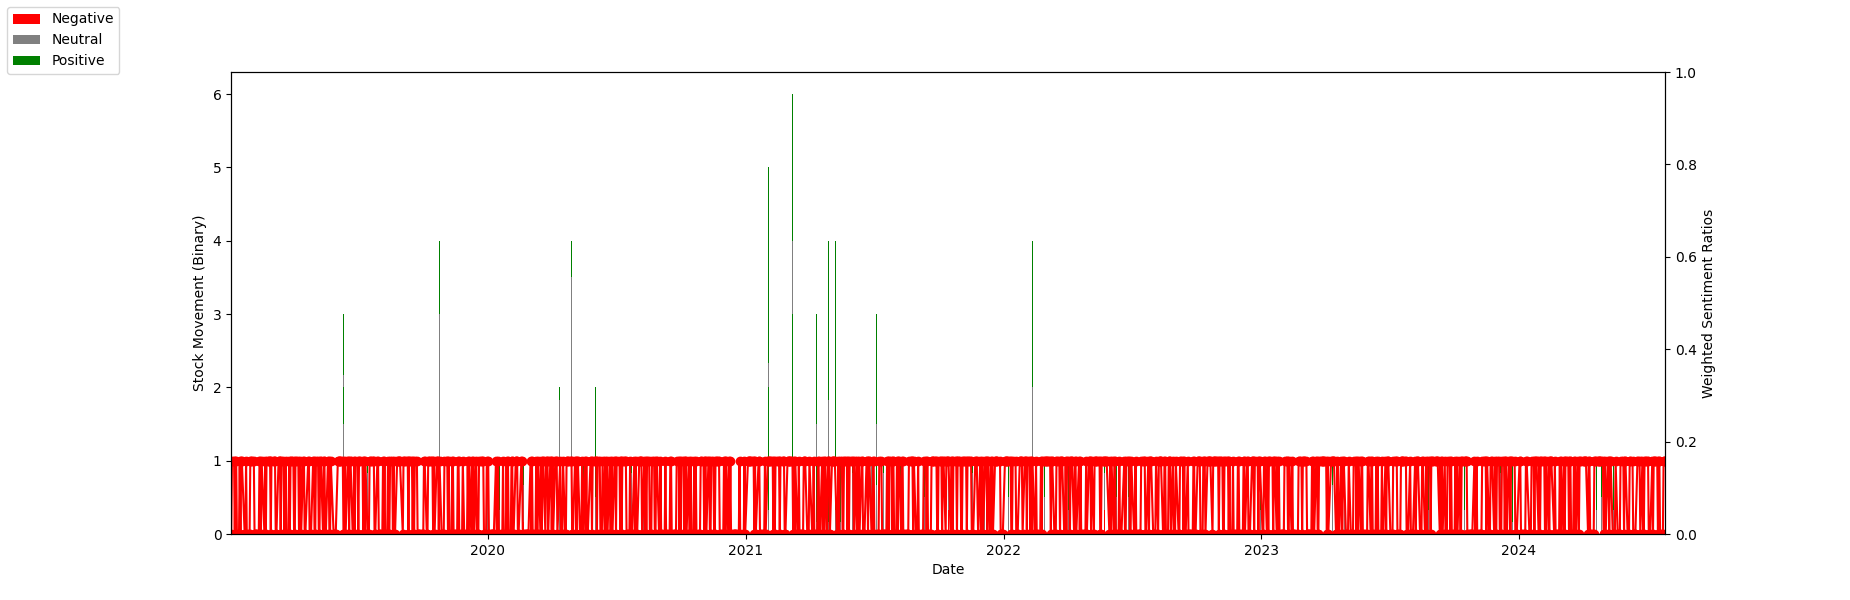

In [16]:
# Visualize Example Stock Price Movements (Up/Down) with Article Counts
%matplotlib ipympl
tz = pytz.timezone('America/New_York')

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2  # points

ret_binary = ret_df['CVX'].apply(lambda x: 1 if x > 0.0 else 0)

ax1.plot(ret_df.index, ret_binary, 'ro-', picker=tolerance)

# Calculate weighted values
dates = df_merged['Date']
weights = {
    "Negative": (df_merged['Neg_ratio_avg'] * df_merged['article_count']).tolist(),
    "Neutral": (df_merged['Neu_ratio_avg'] * df_merged['article_count']).tolist(),
    "Positive": (df_merged['Pos_ratio_avg'] * df_merged['article_count']).tolist()
}

colors = {
    "Negative": 'red',
    "Neutral": 'gray',
    "Positive": 'green'
}

ax2 = ax1.twinx()

width = 0.1
bottom = np.zeros(len(dates))

for sentiment, weight in weights.items():
    p = ax1.bar(dates, weight, width, label=sentiment, bottom=bottom, color=colors[sentiment])
    bottom += weight

ax1.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())
ax2.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())

# Add labels and legend
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Movement (Binary)')
ax2.set_ylabel('Weighted Sentiment Ratios')
fig.legend(loc='upper left')

plt.show()




def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    #query = 'summarize the top news articles for chevron?'
    #top_results = 3
    #print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)

In [17]:
# prep data for modeling
df_dropna = df_merged.dropna()

# Convert the 'Date' column to datetime using .loc to avoid the warning
df_dropna.loc[:, 'Date'] = pd.to_datetime(df_dropna['Date'])

# Define the split dates
base_date = pd.to_datetime('2021-01-01')
split_date = pd.to_datetime('2023-01-01')

# Split the DataFrame
train_df = df_dropna[(df_dropna['Date'] < split_date) & (df_dropna['Date'] >= base_date)]
test_df = df_dropna[df_dropna['Date'] >= split_date]

# Define input variables
X_train_df = train_df.drop(columns=['Date', 'Ticker', 'Returns'])
X_test_df = test_df.drop(columns=['Date', 'Ticker', 'Returns'])

# Define target variable
y_train_df = train_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)
y_test_df = test_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)

# If you need to separate features and labels
X_train = X_train_df
y_train = y_train_df

X_test = X_test_df
y_test = y_test_df

print(len(X_train), len(y_train), len(X_test), len(y_test))

2130 2130 1360 1360


Train Accuracy: 0.4868544600938967
Test Accuracy: 0.47352941176470587


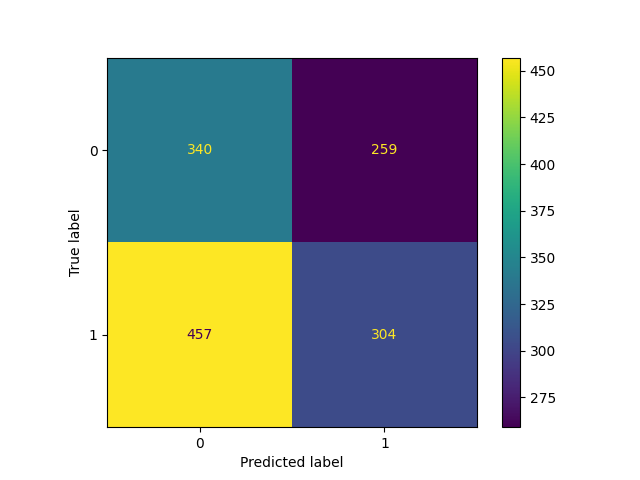

In [18]:
############# Train Support Vector Maching (SVM) #########
# Initialize lists to store training sizes and corresponding accuracies
training_sizes = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

# Loop over different training set sizes
svm = SVC(kernel='sigmoid', random_state=42)
svm.fit(X_train, y_train)

# Predict on the training and test data
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Calculate accuracy for the training and test data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Train Accuracy:',train_accuracy)
print('Test Accuracy:',test_accuracy)

ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}
Train Accuracy: 0.5276995305164319
Test Accuracy: 0.5360294117647059
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.08      0.13       599
           1       0.55      0.90      0.68       761

    accuracy                           0.54      1360
   macro avg       0.46      0.49      0.41      1360
weighted avg       0.47      0.54      0.44      1360



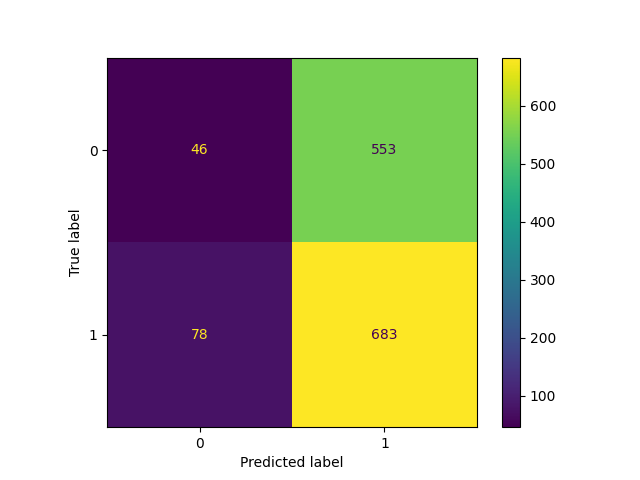

In [19]:
# Initialize lists to store training sizes and corresponding accuracies
training_sizes = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['sigmoid']
}

# Create a Support Vector Machine classifier
svm = SVC(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Train the classifier on the training set
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_

# Predict on the training and test data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate accuracy for the training and test data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [20]:
# Set up for SVM on the Full Dataset

# prep data for modeling
df_dropna = df_merged.dropna()

# Convert the 'Date' column to datetime using .loc to avoid the warning
df_dropna.loc[:, 'Date'] = pd.to_datetime(df_dropna['Date'])

# Define min and max dates
min_date_full = df_dropna['Date'].min()
max_date_full = df_dropna['Date'].max()

# Define the split dates
base_date_full = min_date_full
split_date_full = max_date_full

# Split the DataFrame
train_df_full = df_dropna[(df_dropna['Date'] < split_date_full) & (df_dropna['Date'] >= base_date_full)]
test_df_full = df_dropna[(df_dropna['Date'] < split_date_full) & (df_dropna['Date'] >= base_date_full)]

# Define input variables
X_train_full = train_df_full.drop(columns=['Date', 'Ticker', 'Returns'])
X_test_full = test_df_full.drop(columns=['Date', 'Ticker', 'Returns'])

# Define target variable
y_train_full = train_df_full['Returns'].apply(lambda x: 1 if x > 0.0 else 0)
y_test_full = test_df_full['Returns'].apply(lambda x: 1 if x > 0.0 else 0)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train Accuracy: 0.5289688349717633
Test Accuracy: 0.5289688349717633
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.07      0.12      2256
           1       0.53      0.94      0.68      2525

    accuracy                           0.53      4781
   macro avg       0.52      0.50      0.40      4781
weighted avg       0.52      0.53      0.42      4781



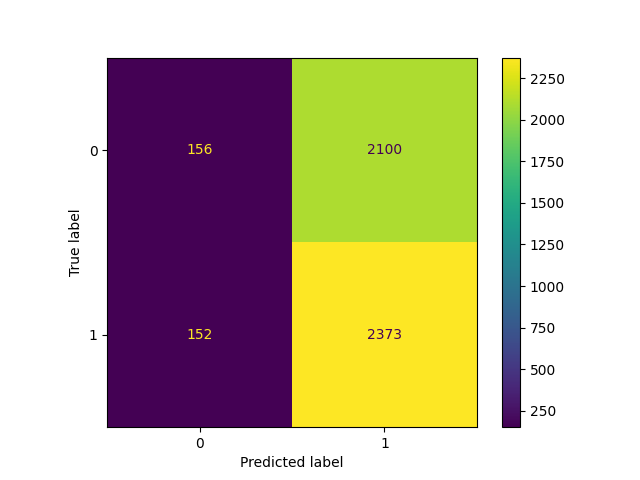

In [23]:
# Train and Test SVM Model on Full Data Set

# Define the parameter grid
param_grid_full = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['sigmoid']
}

# Create a Support Vector Machine classifier
#svm_full = SVC(random_state=42)

# Initialize GridSearchCV
#grid_search_full = GridSearchCV(estimator=svm_full, param_grid=param_grid_full, cv=5, n_jobs=-1, verbose=2)

# Train the classifier on the training set
grid_search.fit(X_train_full, y_train_full)

# Output the best parameters
#print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator for predictions
best_model_full = grid_search.best_estimator_

# Predict on the training and test data
y_train_pred_full = best_model_full.predict(X_train_full)
y_test_pred_full = best_model_full.predict(X_test_full)

# Calculate accuracy for the training and test data
train_accuracy_full = accuracy_score(y_train_full, y_train_pred_full)
test_accuracy_full = accuracy_score(y_test_full, y_test_pred_full)

print('Train Accuracy:', train_accuracy_full)
print('Test Accuracy:', test_accuracy_full)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_full, y_test_pred_full))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model_full, X_test_full, y_test_full)

In [22]:
# Ensure the correct indices are used for predictions
train_indices = train_df_full.index
test_indices = test_df_full.index

# Combine predictions for the entire DataFrame
df_dropna['Predicted_Class'] = np.nan
df_dropna.loc[train_indices, 'Predicted_Class'] = y_train_pred_full
df_dropna.loc[test_indices, 'Predicted_Class'] = y_test_pred_full

# Display the updated DataFrame
display(df_dropna.head())
display(df_dropna.tail())

<ipython-input-22-1410b28e5d7b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['Predicted_Class'] = np.nan


,Ticker,Date,article_count,Finance,Production,Reserves_MA,Regulatory,Green_Energy,OG_Price,Neu_ratio_avg,Pos_ratio_avg,Neg_ratio_avg,Returns,Predicted_Class
0,BP,2019-02-20 00:00:00,1,1,1,0,0,0,1,0.500000,0.500000,0.000000,0.002359,1.0
1,BP,2019-04-30 00:00:00,2,2,2,2,0,2,0,0.333333,0.666667,0.000000,0.016504,1.0
2,BP,2019-05-02 00:00:00,2,2,2,1,0,1,0,0.500000,0.500000,0.000000,-0.010446,1.0
3,BP,2019-06-05 00:00:00,1,1,0,0,1,0,-1,0.500000,0.333333,0.166667,-0.007737,1.0
4,BP,2019-07-06 00:00:00,1,0,0,0,0,0,0,1.000000,0.000000,0.000000,0.023024,1.0


,Ticker,Date,article_count,Finance,Production,Reserves_MA,Regulatory,Green_Energy,OG_Price,Neu_ratio_avg,Pos_ratio_avg,Neg_ratio_avg,Returns,Predicted_Class
5595,XOM,2024-04-30 00:00:00,1,1,1,1,0,1,0,0.333333,0.666667,0.0,-0.011451,1.0
5596,XOM,2024-05-02 00:00:00,1,0,0,1,0,1,0,0.666667,0.333333,0.0,0.001810,1.0
5597,XOM,2024-06-01 00:00:00,1,1,1,1,0,1,1,0.166667,0.833333,0.0,-0.015553,1.0
5598,XOM,2024-06-04 00:00:00,1,0,1,1,0,1,0,0.500000,0.500000,0.0,-0.015553,1.0
5599,XOM,2024-07-03 00:00:00,1,1,1,1,0,1,0,0.333333,0.666667,0.0,0.005080,1.0
